# Finesse for LIGO: Introducing 'Site Files'

Author: Anna Green

_This notebook was developed as part of a series of tutorial workshops at the University of Florida in 2019. It is currently in the process of being 'polished' to fit the Learn Interferometry course._

## Goal For Today
Today the goal is to introduce the so-called 'site files': what they are, what they look like, where to find them, and how to start using them. 

**Purpose of the site files:**
 - multi-user
 - long-term
 - multi-purpose
 - *base* for other case-specific work
 
--> set things up a little differently to how you might on your own, and need to bear in mind 'standard practices' that have been developed or are currently the norm.

## Session Outline




From session 1:
essentially we're covering the same things but for a large-scale, long-term, multi-user model:
 - How to approach building a model
    - --> how to approach large files bearing in mind the difference in use case
 - constructing an optical nodal network using Finesse syntax (the `kat` object)
    - --> getting to grips with the site files themselves :
 - using pykat to create, interact with and modify an existing `kat` object
    - --> the full ecosystem
 - some Finesse 'quirks' <s>, e.g. Finesse's definitions of length and curvature</s>

## Tasks

In [1]:
# all the usual stuff we've used before

from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



### taking a look at the LIGO `design.kat` file

Accessing the file: 

1. The raw file: `design.kat` itself
     - gets pre-installed as part of PyKat
     - 'general public' version installed via miniconda/pip: path something like 
         `~/miniconda3/envs/test/lib/python3.7/site-packages/pykat/ifo/aligo/design.kat`
     - 'live'/editable version via the lvc git repo (also finesse)
         - https://git.ligo.org/finesse/finesse and https://git.ligo.org/finesse/pykat
         - then something like 
         `~/GIT/finesse/pykat/pykat/ifo/aligo/design.kat`
     - 'raw' version, just directly what's in the kat file. Could load this in to a kat model using `kat.load("<path>")` but misses the initialisation steps we nearly always need, so instead:
2. Raw file + initial processing to usable state: import via pykat, then use pykat tools

we'll come back to the processing and pykat tools later. for now, let's just take a look at the file itself.

In [2]:
import pykat.ifo.aligo as aligo
base = aligo.make_kat()
print(base)

% Generated by PyKat 03.09.2019 18:07:15

%%% FTblock laser
l L0 125.0 0.0 0.0 ni
bs jitter 1.0 0.0 0.0 0.0 ni n0 dump dump
s lmod1 1.0 n0 n1
mod mod1 9099471.0 0.18 1 pm 0.0 n1 n2
s lmod2 1.0 n2 n3
mod mod2 45497355.0 0.18 1 pm 0.0 n3 nLaserOut
%%% FTend laser

%%% FTblock IMC
s sIMCin 0.0 nLaserOut nMC1in
bs1 MC1 0.006 0.0 0.0 44.59 nMC1in nMC1refl nMC1trans nMC1fromMC3
s sMC1_MC2 16.24057 nMC1trans nMC2in
bs1 MC2 0.0 0.0 0.0 0.82 nMC2in nMC2refl nMC2trans dump
attr MC2 Rcx 27.24
attr MC2 Rcy 27.24
s sMC2_MC3 16.24057 nMC2refl nMC3in
bs1 MC3 0.006 0.0 0.0 44.59 nMC3in nMC3refl nMC3trans nMCreturn_refl
s sMC3substrate 0.0845 1.44963098985906 nMC3trans nMC3ARin
bs2 MC3AR 0.0 0.0 0.0 28.9661 nMC3ARin dump nIMCout dump
s sMC3_MC1 0.465 nMC3refl nMC1fromMC3
%%% FTend IMC

%%% FTblock HAM2
s sHAM2in 0.4282 nIMCout nIM11
bs1 IM1 0.0 0.0 0.0 53.0 nIM11 nIM12 dump dump
s sIM1_IM2 1.2938 nIM12 nIM21
bs1 IM2 0.0 0.0 0.0 7.0 nIM21 nIM22 dump dump
attr IM2 Rcx 12.8
attr IM2 Rcy 12.8
s sIM2_FI 0.2

#### <font color='Teal'> Task: discussion about the `design.kat` file</font>

* General comments
* 'blocks'??
* no xaxis, no detectors, just optics
* 'composite optics' - multiple bs's used to define the central bs, ITMs, ETMs, etc
* nodes with odd/special names, e.g. `nREFL`
 * 

#### <font color='Teal'> Task: identifying the key elements in the file</font>

Use the design.kat file to **sketch** the LIGO core optical layout (PRM to SRM) and identify the names of the main components in the kat file

--> useful reference: my inkscape sketch: <a href="https://git.ligo.org/IFOsim/Finesse_playground/blob/master/anna_green/svg_Finesse_Layouts/aLIGO_fullwsqz_Jan2019.svg"> aLIGO_fullwsqz_Jan2019.svg (via LIGO git)</a>

##### <font color='Teal'> & if there's time</font>
Go back and extend your sketch to include the input and output optical paths (i.e. blocks before the PRC and blocks after the SRC)

### Enhanced functionality via the `aligo` package: `make_kat()` and beyond

The `design.kat` file itself is pretty stable - the aLIGO design is, in principal, still the same as it was in 2010. It can be used on it's own, with some caveats we'll cover later, but it's quite bare-bones. This is where accompanying scripts come in. 

There are 4 files: `ifo/aligo/__init__.py`, `ifo/aligo/plot.py`, and the more general `ifo/__init__.py` and `ifo/plot.py`.  Together they serve several purposes:

2. to store scripts commonly used to manipulate the main kat object
    - e.g. to remove the blocks containing the input optics and automatically reconnect the nodes so the file still runs, and to set the file to a good initial operating point (see below) 
2. to store scripts to make common plots
    - e.g. to plot error signals for the main degrees of freedom in the IFO
1.  to store properties of the detector used to set the model up properly
1. to store components, or set of components that are often needed but would significantly slow down the model if included by default every time
    - usually this is detectors - photodiodes and so on - that have a specific name and purpose. Adding detectors adds to the number of calculations, making it slower.
    
         
All of these scripts are a work in progress. Literally: I added new updates yesterday. So it's sometimes tricky to know what's possible. 
You might have noticed that you can often use the `tab` key to auto-complete function names in python. The same is true here! And it's especially useful for larger kat files where there's lots going on. 

The main ways to find things are:
 - skim through the current kat object
 - 'tab around' `kat.[...]`, `kat.ALIGO_IFO.[...]` and `kat.IFO.[...]` (NB: only works in cells *outside* the cell where the current `kat` is defined, even if you've already run that cell)
 - directly look in the `__init__.py` and `plot.py` files or using the `inspect` package, to see what your function is actually doing...
 
Finding functions: likely locations

<table style="width: 80%;">
  <col width="60">
  <col width="200">
  <tr>
    <th>location</th>
    <th style="text-align:left">contents</th>
  </tr>
  <tr>
      <td><tt>ifo/aligo/__init__.py</tt>:<br> main functions</td>
      <td style="text-align:left"> <b>The main one to look at first</b>. <br>Functions to create the aLIGO pykat object and prepare it for use, using info in the ALIGO_IFO class. <br><b>key functions:</b> <tt>make_kat</tt> and <tt>setup</tt></td>
  </tr>
  <tr>
      <td><tt>ifo/aligo/__init__.py</tt>: <br><tt>ALIGO_IFO</tt> class</td>
    <td style="text-align:left"> aLIGO-specific functions to edit the main kat object where those functions involve interactions between the kat and associated IFO object,<br> e.g. add/remove blocks, set lengths so a certain frequency is resonant, etc</td>
  </tr>
  <tr>
      <td><tt>ifo/aligo/plot.py</tt></td>
    <td style="text-align:left">common ligo-specific plotting functions, such as the QNLS curve or error signals vs DOFs</td>
  </tr>
  <tr>
      <td><tt>ifo/__init__.py</tt></td>
    <td style="text-align:left">Tools that are less detector-specific, plus definitions for classes used in all IFO objects, e.g. <tt>DOF</tt></td>
  </tr>
  <tr>
      <td><tt>ifo/plot.py</tt></td>
    <td style="text-align:left">plotting functions that are less detector-specific.</td>
  </tr>
</table>

#### <font color='Teal'> Task: quick discussion of what `make_kat` does beyond our normal `parse` or `load` options</font>

Didn't just do `kat.load(design.kat)` - we used `make_kat()`.  Essentially that's where all the missing features are!

Run inspect on `aligo.make_kat()` - bit intimidating but quick scan through shows that we basically define a lot of:
 * `port`s of class `Output`  
     - these are essentially key detectors, PDs or PD1s, that are used frequently
 * `signal`s of class `DOF`
     - combine a detector with a type of motion to correspond to a detector signal and its error signal. E.g. `kat.IFO.PRCL` defines the PRCL dof, associating it with the POP_f1 port (a demodulated PD behind PR2)  and the tuning of the PRM, with some scaling etc wrt other DOFs. 

In [3]:
import inspect
print(inspect.getsource(aligo.make_kat))

def make_kat(name="design", katfile=None, verbose = False, debug=False, use_RF_DARM_lock=False,
             keepComments=False, preserveConstants=False):
    """
    Returns a kat object and fills in the kat.IFO property for storing
    the associated interferometer data.
    
    The `name` argument selects from default aLIGO files included in Pykat:
    
    
    keepComments: If true it will keep the original comments from the file
    preserveComments: If true it will keep the const commands in the kat
    """
    names = ['design']
    
    if debug:
        kat = finesse.kat(tempdir=".",tempname="test")
    else:
        kat = finesse.kat()
    
    kat.verbose=verbose
    
    # Create empty object to just store whatever DOFs, port, variables in
    # that will be used by processing functions
    kat.IFO = ALIGO_IFO(kat,
                        # Define which keys are used for a tuning description
                        ["maxtem", "phase"],
                        # Define whi

#### <font color='Teal'> Task: quick examples of using these features </font>

1. add a power detector automatically in the right place (and get the power there)
2. plot the signal used to detect a DOF quickly
3. list all available Outputs (detectors) and DOFs available for use this way

In [4]:
# 1. add a power detector automatically in the right place (and get the power there)

kat = base.deepcopy()
kat.IFO.POW_X.add_signal()
kat.noxaxis=True
o=kat.run()
print(o[kat.IFO.POW_X.name])

707292.367935397


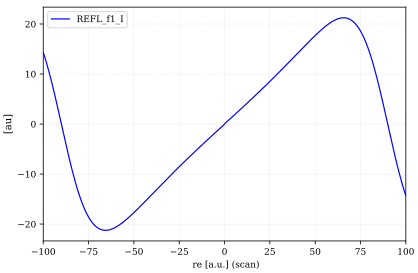

In [5]:
# 2. plot an error signal for a DOF quickly
kat = base.deepcopy()
o = kat.IFO.CARM.scan()
o.plot()

In [6]:
kat.IFO.CARM.signal_name

<bound method DOF.signal_name of <pykat.ifo.DOF object at 0x1819a73c88>>

In [7]:
# list all available detectors (Outputs) or DOFs available for use this way
kat.IFO.Outputs, kat.IFO.DOFs

({'AS_DC': <pykat.ifo.Output at 0x1819a73898>,
  'AS_f1': <pykat.ifo.Output at 0x1819a737f0>,
  'AS_f2': <pykat.ifo.Output at 0x1819a73828>,
  'AS_f36': <pykat.ifo.Output at 0x1819a73860>,
  'POP_f1': <pykat.ifo.Output at 0x1819a73710>,
  'POP_f2': <pykat.ifo.Output at 0x1819a73748>,
  'POW_BS': <pykat.ifo.Output at 0x1819a738d0>,
  'POW_X': <pykat.ifo.Output at 0x1819a73908>,
  'POW_Y': <pykat.ifo.Output at 0x1819a73940>,
  'REFL_f1': <pykat.ifo.Output at 0x1819a73780>,
  'REFL_f2': <pykat.ifo.Output at 0x1819a737b8>,
  'TRX': <pykat.ifo.Output at 0x1819a73978>,
  'TRY': <pykat.ifo.Output at 0x1819a739b0>},
 {'CARM': <pykat.ifo.DOF at 0x1819a73c88>,
  'CHARD_P': <pykat.ifo.DOF at 0x1819a73d68>,
  'CSOFT_P': <pykat.ifo.DOF at 0x1819a73dd8>,
  'DARM': <pykat.ifo.DOF at 0x1819a73cc0>,
  'DARM_h': <pykat.ifo.DOF at 0x1819a73d30>,
  'DHARD_P': <pykat.ifo.DOF at 0x1819a73da0>,
  'DSOFT_P': <pykat.ifo.DOF at 0x1819a73e10>,
  'MICH': <pykat.ifo.DOF at 0x1819a73c50>,
  'MICH_P': <pykat.ifo.DOF

### typical basic usage & first sanity check: QNLS plot
#### <font color='Teal'> Task: plot the quantum-noise-limited sensitivity of the LIGO design.</font>
2 methods. (1) we do it by hand, and (2) we make use of a handy function included in the ligo plotting tools.
 
Using the plotting tool, we just need to 
1. import the aligo plotting tools package:
``` python
import pykat.ifo.aligo.plot as aligoplt
```
2. use the `strain_sensitivity()` function from this package to directly plot the curve with some default parameter ranges.
         - take a look at the function iteself in `pykat/ifo/aligo/plot.py` to see what's actually going on.

**Use either method to plot the quantum-limited sensitivity of the LIGO design.** How does it compare to the design curve we usually show, such as that shown on <a href=http://gwplotter.com/>gwplotter.com</a>?

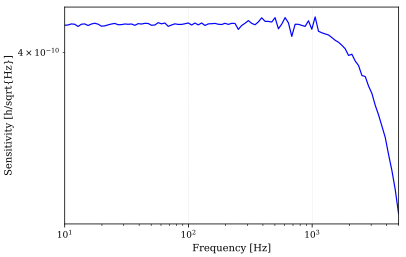

In [8]:
import pykat.ifo.aligo.plot as aligoplt
aligoplt.strain_sensitivity(base)

either way, this doesn't look right. In fact, it looks rubbish! 

#### <font color='Teal'> Task: discussion</font>
What are we missing? 

Ans: we're not at an **operating point**! 

##### What is an operating point?
 * operating point = condition in which ifo can be used as intended. In particular for LIGO, all optics correctly tuned such that power high & low in the correct places.
 * single cavity: operating point might be that the cavity is on resonance & can be used as a reference cav. 
     - in Finesse, this is easy: phi=0 on both mirrors and automatically everything is fine.
 * LIGO: multiple cavities, thick, realistic optics. 
      - Finesse with all tunings to 0 is no longer quite correct: phase accumulates going from one optic to the next, amplified by cavities, etc, so don't have 'phi=0 is resonant' for all optics any more. 
 * need to find a usable tuning for each optic. 
 * in cases where the file is pretty 'clean' - i.e. not many distortions that siignificantly affect accumulated phase/Gouy phase, we can use the script `setup` to run through the file, using realistic error signals for the main degrees of freedom, to set the tunings of the main optics to get everything resonant (or anti-resonant) as required. 
 * won't go over it in detail today, maybe next time? 
 * but in essence, need to run this at the start of every model. 


#### <font color='Teal'> Task: `setup` the ligo file, then plot the quantum-noise-limited sensitivity of the LIGO design again. </font>

all we need is 
```python 
base2 = aligo.setup(base)
aligoplt.strain_sensitivity(base2)
```

In [ ]:
base2 = aligo.setup(base)
aligoplt.strain_sensitivity(base2)

#### <font color='Teal'> Task: Discussion of results </font>

##### Option 1: masses missing
You might see this version which is flat at low frequencies - no Quantum Radiation Pressure Noise taken into account! 

Actually, we spotted this a while ago, I made a corrected version that's propagating through the system now... If not, main issue is that the mirrors get *fixed* in place by setup() & have infinite mass. If we restore the mass values, they act as suspended free masses and we see the 'full' QNLS plot:

In [ ]:
LIGO = base2.deepcopy()
LIGO.ETMX.mass = LIGO.ETMY.mass = LIGO.ITMX.mass = LIGO.ITMY.mass = 40
aligoplt.strain_sensitivity(LIGO)

##### Option 2: what does the function do? why?

###### <font color='Teal'> Short version: Let's inspect the built-in function and discuss it</font>

In [ ]:
print(inspect.getsource(aligoplt.strain_sensitivity))

In [ ]:
print(base.IFO.DARM_h.signal())
print(base.IFO.DARM_h.transfer())
print(base.IFO.DARM_h.optics)
print(base.IFO.DARM.optics)

print(base.IFO.DARM_h.fsig())

###### <font color='Teal'> Longer version: Let's recreate this by hand, with no IFO-sourced detectorsm to show we can, then compare the two side-by-side</font>

In [ ]:
kat = base2.deepcopy()
kat.parse("""
fsig DARM_h LY phase 1.0 180.0 1
fsig DARM_h LX phase 1.0 0.0 1
qnoisedS NSR 1 $fs nAS
xaxis DARM_h f log 10 5000 100
yaxis log abs
""")
o = kat.run()
o.plot(['NSR'])